### Notebook to genereate mean vertical profiles from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [27]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import sys
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from stratiform_index import stratiform_index
from mask_tc_track import mask_tc_track

#### Time selection

#### Directories

In [28]:
storm = 'haiyan'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

imemb='memb_01'

datdir = main+storm+'/'+imemb+'/ctl/post/d02/v2/'
print(datdir)

/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ctl/post/d02/v2/


#### Read variables

In [29]:
# Two-dimensional variables

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
# varfil_strat = Dataset(datdir+'strat_orig.nc') # this opens the netcdf file
# strat1 = varfil_strat.variables['strat'][0,:,:,:]
varfil_strat = Dataset(datdir+'strat_origit1.nc') # this opens the netcdf file
strat1 = varfil_strat.variables['strat'][0:1,:,:,:]
varfil_strat.close()

varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat2 = varfil_strat.variables['strat'][0:1,:,:,:]
varfil_strat.close()

it0=37
varfil_strat = Dataset(datdir+'W.nc') # this opens the netcdf file
pres = varfil_strat.variables['pres'][:] # hPa
w = varfil_strat.variables['W'][it0:it0+1,:,:,:]
varfil_strat.close()

bv_shape = np.shape(w)
nt = bv_shape[0]
nz = bv_shape[1]
nx1 = bv_shape[2]
nx2 = bv_shape[3]

In [30]:
# stratdiff = strat2[0,0,:,:] - strat3[0,:,:]
# print(stratdiff.max())
# print(stratdiff.min())

#### Average for Conv, Strat, and Anvil

In [31]:
process = subprocess.Popen(['ls '+main+storm+'/memb_01/ctl/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()

ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit for masking around TC center
track_file = datdir+'../../../track_'+var_track+'_'+ptrack+'hPa.nc'

w = mask_tc_track(track_file, rmax, w, lon, lat, 36, 37)
strat1 = mask_tc_track(track_file, rmax, strat1, lon, lat, 36, 37)
strat2 = mask_tc_track(track_file, rmax, strat2, lon, lat, 36, 37)

In [32]:
print(np.ma.MaskedArray.count(strat1))
print(np.ma.MaskedArray.count(strat2))
print(np.ma.MaskedArray.count(w))

155023
155023
6045897


In [33]:
w_c1 = np.ma.masked_where((np.repeat(strat1,nz,axis=1) != 1), w, copy=True)
w_s1 = np.ma.masked_where((np.repeat(strat1,nz,axis=1) != 2), w, copy=True)
w_a1 = np.ma.masked_where((np.repeat(strat1,nz,axis=1) < 2), w, copy=True)

w_c2 = np.ma.masked_where((np.repeat(strat2,nz,axis=1) != 1), w, copy=True)
w_s2 = np.ma.masked_where((np.repeat(strat2,nz,axis=1) != 2), w, copy=True)
w_a2 = np.ma.masked_where((np.repeat(strat2,nz,axis=1) < 2), w, copy=True)

count_c1 = np.ma.MaskedArray.count(w_c1)/nz
count_s1 = np.ma.MaskedArray.count(w_s1)/nz
count_a1 = np.ma.MaskedArray.count(w_a1)/nz

count_c2 = np.ma.MaskedArray.count(w_c2)/nz
count_s2 = np.ma.MaskedArray.count(w_s2)/nz
count_a2 = np.ma.MaskedArray.count(w_a2)/nz

w_c1 = np.mean(w_c1,axis=(0,2,3))
w_s1 = np.mean(w_s1,axis=(0,2,3))
w_a1 = np.mean(w_a1,axis=(0,2,3))
w_c2 = np.mean(w_c2,axis=(0,2,3))
w_s2 = np.mean(w_s2,axis=(0,2,3))
w_a2 = np.mean(w_a2,axis=(0,2,3))

---
### Plotting routines

In [34]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Plot profiles

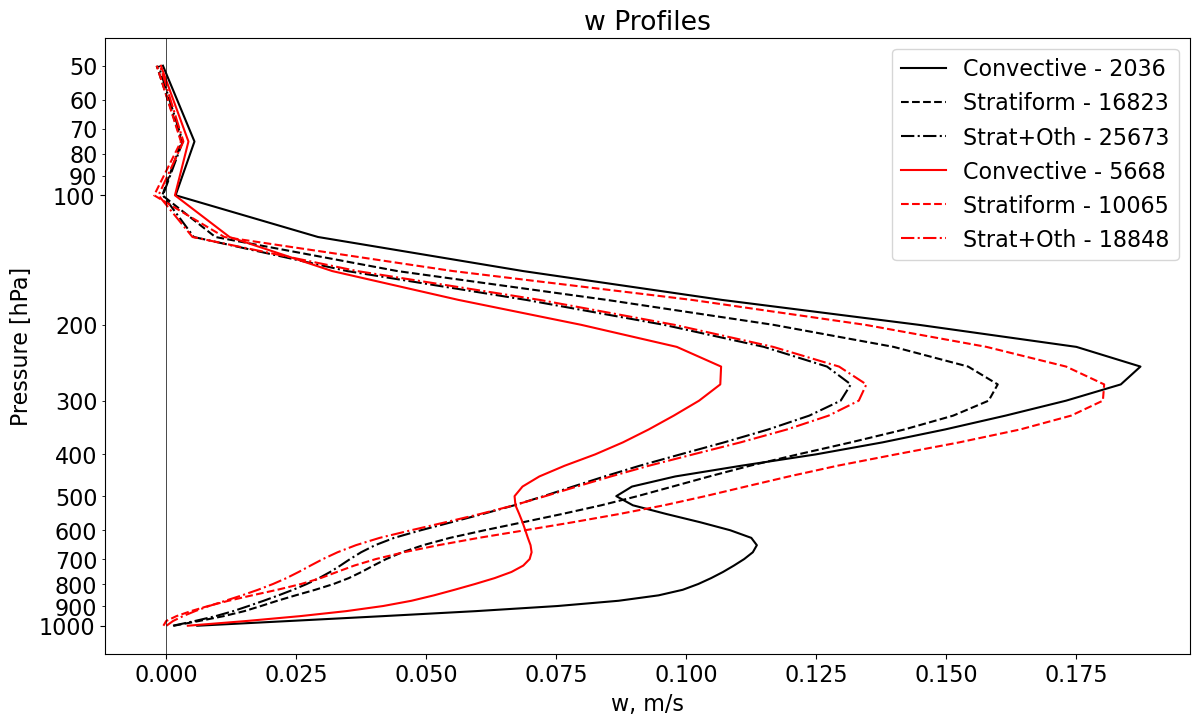

In [35]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('w Profiles')
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

plt.plot(w_c1, pres, "-k", label="Convective - "+str(int(count_c1)))
plt.plot(w_s1, pres, "--k", label="Stratiform - "+str(int(count_s1)))
plt.plot(w_a1, pres, "-.k", label="Strat+Oth - "+str(int(count_a1)))
plt.plot(w_c2, pres, "-r", label="Convective - "+str(int(count_c2)))
plt.plot(w_s2, pres, "--r", label="Stratiform - "+str(int(count_s2)))
plt.plot(w_a2, pres, "-.r", label="Strat+Oth - "+str(int(count_a2)))

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('w, m/s')
# plt.xlim(np.min(bins), np.max(bins))
plt.legend(loc="upper right")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)